# E-mail Sentiment Analysis Using Python & Microsoft Azure

### *About*
This notebook is focused on performing sentiment analysis on a CSV export from Outlook. We're using our Sent Items folder specifically, as I'm curious to see what ratings I have based on how I respond to individual employees. This is mostly for fun and practice, but can be used in some practical situations.

### *Why?*
I'm ultimately exploring ways to determine workplace happiness by using historical data to ultimately try to predict future happiness over tenure at a company. There are a ton of moving pieces here, and some that are going to be hard to measure, but this is mostly a fun exercise that allows me to get comfortable with different languages and services. 

### *Medium.com*
There is also an article posted on Medium.com that leverages this notebook. There are follow-up parts being created that will explore the data in more depth, as well as looking at other data we can pull in to complement what we've done here.

## Package Installation & Preparation

In [1]:
!pip install azure-ai-textanalytics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from azure.ai.textanalytics import TextAnalyticsClient
from azure.core.credentials import AzureKeyCredential

#Key and enpoint from Azure Text Analytics API service
key = "f7c7c91cd70e493ea38521d1cbf698aa"
endpoint = "https://mediumapi.cognitiveservices.azure.com/"


### Azure Authentication & Analysis Functions
The first function here is strictly "canned" for authentication purposes to the Text Analytics API. The second function we've modified quite a bit from the original found in the Microsoft Quickstart. Here we're going to use a dictionary frequency table to keep track of our sentiment result counts, as well as for future plotting. We have an errors list setup so that we can work to remove found errors later.

In [3]:
#Creating the Azure authentication function
def authenticate_client():
    ta_credential = AzureKeyCredential(key)
    text_analytics_client = TextAnalyticsClient(endpoint=endpoint, credential=ta_credential)
    return text_analytics_client

#Core function for running sentiment analysis
#Modified to fit our specific needs
#Added global variables we'll use later in this notebook
def sentiment_analysis_example(client,list_name): 
    global senti_results 
    senti_results = {'Positive':0,'Neutral':0,'Negative':0,'Unknown':0}
    global senti_errors
    senti_errors = []
    documents = list_name
    for row in documents:
        response = client.analyze_sentiment(documents = row)[0]
        try:
            if response.sentiment == "positive":
                senti_results['Positive'] += 1
            elif response.sentiment == "neutral":
                senti_results['Neutral'] += 1
            elif response.sentiment == "negative":
                senti_results['Negative'] +=1
            else:
                senti_results['Unknown'] +=1
        except:
            senti_errors.append(row)
    return(senti_results,senti_errors)

#Assigning authentication function to object
client = authenticate_client()


### Loading & Exploring Our Data
Loading our CSV file into a DataFrame and reviewing the data. For our e-mail format we needed to use ISO 8859-1.

In [4]:
#Assign your filename to a variable
emailFile = 'BenSent.CSV'

#Display the first 5 rows of our CSV to inspect
#Notice encoding - this seemed to work for our CSV
email_data = pd.read_csv(emailFile,encoding='ISO 8859-1')
email_data.head()

,Subject,Body,From: (Name),From: (Address),From: (Type),To: (Name),To: (Address),To: (Type),CC: (Name),CC: (Address),CC: (Type),BCC: (Name),BCC: (Address),BCC: (Type),Billing Information,Categories,Importance,Mileage,Sensitivity
0,Re: ACTION REQUIRED: Missing Timecard for w/e ...,Since they didn't go over timecard entries dur...,Ben Prescott,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,Derek Smith,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
1,Re: Missing skills on Resouce Request,I went through all the ones I've heard of and ...,Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Ryan Heringhaus,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,Dan Wittenberg;Mickey Weibeler;Krista Meschino,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX;EX;EX,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
2,Re: New Payroll Schedule - Missing Deposit,"Got it, looks like it just came through. Thank...",Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
3,Re: New Payroll Schedule - Missing Deposit,"Any update on this? \r\n\r\nRegards,\r\nBen\r\...",Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal
4,Re: New Payroll Schedule - Missing Deposit,Thanks Michael. I have some others on my team...,Ben Prescott,/O=EXCHANGELABS/OU=EXCHANGE ADMINISTRATIVE GRO...,EX,Michael Hoehne,/o=ExchangeLabs/ou=Exchange Administrative Gro...,EX,AHEAD Human Resources,hr@thinkahead.com,SMTP,NaN,NaN,NaN,NaN,NaN,Normal,NaN,Normal


# Cleaning & Preparing The Dataset 

### Body Column
We're going to focus on just the Body column from our dataset, as the rest is irrelevant when determining sentiment.

In [5]:
#Assign Body column to new object
email_body = email_data['Body']

#Display top 5 rows and the overall length of the series
print(email_body.head())
print('\n')
print("Starting email count:",email_body.shape)

0    Since they didn't go over timecard entries dur...
1    I went through all the ones I've heard of and ...
2    Got it, looks like it just came through. Thank...
3    Any update on this? \r\n\r\nRegards,\r\nBen\r\...
4    Thanks Michael.  I have some others on my team...
Name: Body, dtype: object


Starting email count: (1675,)


### Removing \r and \n Characters
Replacing found strings for \r and \n so that we don't try to analyze those.

In [6]:
#Removing \r and \n characters from strings
email_body = email_body.str.replace("\r","")
email_body = email_body.str.replace("\n","")

#Display top 5 rows and the overall length of the series
print(email_body.head())
print('\n')
print("Current e-mail count:",email_body.shape)

0    Since they didn't go over timecard entries dur...
1    I went through all the ones I've heard of and ...
2    Got it, looks like it just came through. Thank...
3    Any update on this? Regards,BenOn Wed, Jan 15,...
4    Thanks Michael.  I have some others on my team...
Name: Body, dtype: object


Current e-mail count: (1675,)


### Partitioning by E-mail Signature
Finding all rows/strings that have "Regards" in them (to signify the start of my automatically added e-mail signature) and added them to separate columns temporarily. We'll drop these columns soon so we have just the starting data from the email. 

In [7]:
#Removing trailing email threads after start of my email signature
split_df = email_body.str.partition("Regards")
print(split_df[0:3])
print('\n')
print("Current e-mail count:",split_df.shape)

                                                   0        1  \
0  Since they didn't go over timecard entries dur...  Regards   
1  I went through all the ones I've heard of and ...  Regards   
2  Got it, looks like it just came through. Thank...  Regards   

                                                   2  
0  ,BenSent from my Verizon, Samsung Galaxy smart...  
1  ,BenOn Thu, Jan 16, 2020, 6:37 PM Ryan Heringh...  
2  ,BenOn Wed, Jan 15, 2020, 2:59 PM Michael Hoeh...  


Current e-mail count: (1675, 3)


### Dropping Partitioned Columns & NaN Rows
Simply dropping the second and third columns from our last step and removing empty rows.

In [8]:
#Removing extra fluff from partitioning
clean_col = split_df.drop(columns=[1,2]) #1 contains "Regards", 2 contains trailing text
#Removing rows with NaN - no data
clean_nan = clean_col.dropna()

print("E-mail count before NaN removal:",clean_col.shape[0]) #Display before NaN removal
print("E-mail count after NaN removal:",clean_nan.shape[0]) #Display before NaN removal

E-mail count before NaN removal: 1675
E-mail count after NaN removal: 1642


### Column Rename, PTO & Forwarded Message Removal
Adding a name to our column header for easier identification and also finding rows that contain my default PTO response and any forwarded messages without responses first and removing them.

In [9]:
#Updating the primary column with name EmailBody
clean_nan = clean_nan.rename(columns={0:"EmailBody"})

#Remove emails with default out of office reply
clean_pto = clean_nan[~clean_nan.EmailBody.str.contains("Hello,I am currently")]

#Remove emails with a forwarded message
cleaned_df = clean_pto[~clean_pto.EmailBody.str.contains("---------- Forwarded message ---------")]

print("E-mail count before removals:",clean_nan.shape[0]) #Pre PTO count
print("E-mail count after removing PTO messages:",clean_pto.shape[0]) #Post PTO count
print("E-mail count after also removing forwarded messages:",cleaned_df.shape[0]) #Post fwd removal

E-mail count before removals: 1642
E-mail count after removing PTO messages: 1460
E-mail count after also removing forwarded messages: 1399


### Spot Check Review
Simply reviewing the data again to see where we're at and what looks "wrong".

In [10]:
#Reviewing the new data
#Some rows still appear to be empty we'll clean this later.
print(cleaned_df)
print('\n')
print("Current e-mail count:",cleaned_df.shape)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1399 rows x 1 columns]


Current e-mail count: (1399, 1)


### Replacing Empty Rows With NaN
Based on our last review I was able to find empty rows still, but something was keeping them from being caught by .dropna. We're going to find some spaces and replace them with NaN to drop. We'll catch additional errors later.

In [11]:
#Considering we know we still have rows with no data, we'll replace the empty space with NaN
#We can see all visible rows with nothing now show NaN
cleaned_df['EmailBody'].replace(" ",np.nan,inplace=True)
print(cleaned_df)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1399 rows x 1 columns]


C:\Users\ben.prescott\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Dropping New NaN Rows
Now that we've replaced blank rows with NaN we can target and drop them as well.

In [12]:
#We can now find all rows with NaN and drop them using pd.dropna
cleaned_df = cleaned_df.dropna()
print(cleaned_df)
print('\n')
print("E-mail count after dropping empty rows/rows with NaN:",cleaned_df.shape)

                                              EmailBody
0     Since they didn't go over timecard entries dur...
1     I went through all the ones I've heard of and ...
2     Got it, looks like it just came through. Thank...
3                                  Any update on this? 
4     Thanks Michael.  I have some others on my team...
...                                                 ...
1670  Oof. You can include me and I can provide some...
1671  You want me to get involved with this? I can p...
1672  Looks like Bruno just looped him in. Ill step...
1673  Fyi this feels weird and is being built in a s...
1674  Updated the NVA verbiage from Cisco to Palo Al...

[1288 rows x 1 columns]


E-mail count after dropping empty rows/rows with NaN: (1288, 1)


### Sentiment Analysis Prep
We're going to iterate over our DataFrame and dump each string into a list of lists. We're going to use this in preparation to send each list to our API and return a result.

In [13]:
#Create an empty list to store values
#Iterate over each row in the dataframe and append it to the list

senti_list = []

for row in range((cleaned_df.shape[0])):
    senti_list.append(list(cleaned_df.iloc[row,:]))
    
#Length of list matches length of old df 
print("E-mail count before error removal, ready for analysis:",len(senti_list))

E-mail count before error removal, ready for analysis: 1288


# Sentiment Analysis & Error Removal

### Analysis Round #1
Initial round of analysis. Passing in the list called "senti_list".

In [14]:
#Trigger the sentiment analysis function, passing in our list of lists
sentiment = sentiment_analysis_example(client,senti_list)

### Analysis Round #1 - Output
Reviewing the output of Round 1. We can see that we have some Unknown results, meaning the API couldn't make an overall determination. We can also see we have some errors as part of the output. In the function defined at the beginning, we have a Try\Except setup to catch errors and log the row causing the error into an empty list. 

Based on the output we can determine we have random spacing causing errors, as we can't determine the sentiment of nothing. :)


In [15]:
print(senti_results)
print("\n")
print("Sentiment errors:",senti_errors)
print("Error count:",len(senti_errors))

{'Positive': 360, 'Neutral': 412, 'Negative': 149, 'Unknown': 356}


Sentiment errors: [['  '], ['  '], ['  '], ['  '], ['  '], [''], ['  '], [''], ['  '], ['  '], ['']]
Error count: 11


### Removing Erroring Rows
Iterating over both the errors list, as well as the original dataset and removing rows that match the errors in the errors list. We can see we removed exactly 11 rows, which matches up with our errors list.

In [16]:
#Removing the errors from our list of lists
#Assigning to a new variable so we have the unmodified original
senti_cleaned = senti_list

for i in senti_errors:
    for row in senti_cleaned:
        if i == row:
            senti_cleaned.remove(row)
            
print("E-mail count after removing error rows. Final used for analysis:",len(senti_cleaned))

E-mail count after removing error rows. Final used for analysis: 1277


### Analysis Round #2
Second round of analysis after cleaning up the errors. Also using a new object containing our data to keep from impacting our original.

In [17]:
#Triggering next run of analysis on the final dataset
sentiment = sentiment_analysis_example(client,senti_cleaned)

### Analysis Round #2 - Output
We can see that we  no longer have any errors and that all of our results are being analyzed. We still have a good amount of Unknown responses, but that could be caused by a variety of issues. I can already assume many of my responses are simply images or GIFs that aren't distinguishable. :) We can continue to clean if we want, but for funsies we'll carry on.

In [18]:
#Displaying the sentiment analysis results
print(senti_results)
print("\n")
print("Sentiment errors:",senti_errors)
print("Error count:",len(senti_errors))

{'Positive': 360, 'Neutral': 412, 'Negative': 149, 'Unknown': 356}


Sentiment errors: []
Error count: 0


# Visualization

### Plotting Percentages & Counts
To end on a basic note, we're going to plot the percentage of our results against the total emails, as well as the counts of each one. We'll do this in a nice pie and bar chart. 

In a future notebook we'll continue on with this and find ranges of the individual scores presented, not just the overall label.

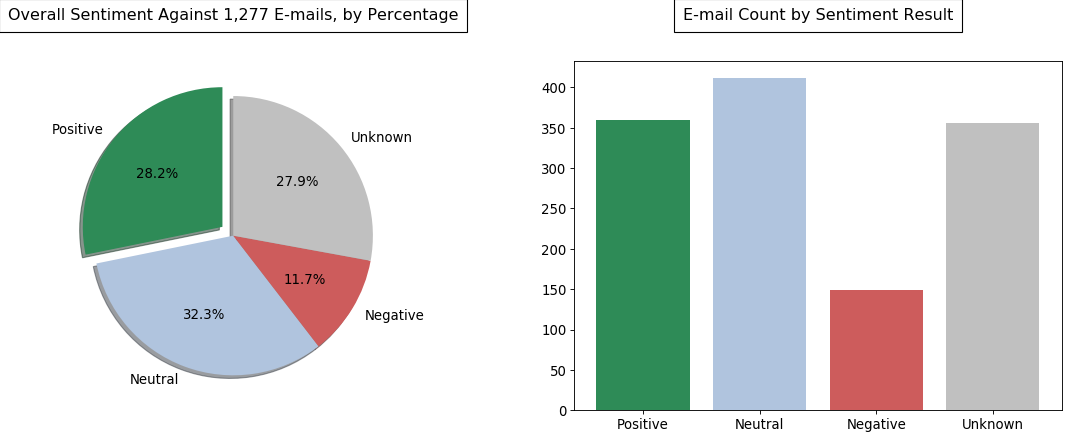

In [19]:
#Setting our Key/Value pairs from our results
keys = senti_results.keys()
values = senti_results.values()

#Establishing some format changes for our charts
figure(num=None, figsize=(8,8),dpi=80)
colors = ['seagreen','lightsteelblue','indianred','silver']
explode = (0.1, 0, 0, 0)
plt.rcParams.update({'font.size': 12})

#Creating the first plot (pie chart)
plt.subplot(221)
plt.pie(values,labels=keys,colors=colors, explode=explode,autopct='%1.1f%%',shadow=True,startangle=90)
plt.title('Overall Sentiment Against 1,277 E-mails, by Percentage',bbox={'facecolor':'1','pad':8},y=1.10)

#Creating the second plot (bar chart)
plt.subplot(222)
plt.title('E-mail Count by Sentiment Result',bbox={'facecolor':'1','pad':8},y=1.10)
plt.bar(keys,values,width=.8,color=colors)

#Adjusting the spacing/padding between subplots
plt.subplots_adjust(left=0.125, bottom=0.1, right=1.8, top=1.3, wspace=0.2, hspace=0.2)

#Displaying the plots
plt.show()